# General Overview - Statistical Analysis

- Are there variables that are particularly significant in terms of explaining the answer to your project question?
- Are there significant differences between subgroups in your data that may be relevant to your project aim?
- Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
- What are the most appropriate tests to use to analyze these relationships?

Use chi square test for categorical variables.

Some categorical variables are nominal attributes, meaning that the variables in each column are independent of each other (i.e. no sense of order). Others are binary and have only two answer choices: Yes and No.

Using Label Encoder or One-Hot Encoder can impact our model results. We can try to use both in order to determine which encoder is the more accurate one.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, t, chisquare
from numpy.random import seed
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [41]:
data = pd.read_csv('tree_census_stat_ready.csv', index_col=0, encoding='utf-8') # import data
tree = data.copy() # save a copy of data as tree

In [42]:
tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651535 entries, 0 to 683787
Data columns (total 22 columns):
tree_id         651535 non-null int64
tree_dbh        651535 non-null int64
curb_loc        651535 non-null object
health          651535 non-null object
spc_common      651535 non-null object
steward         651535 non-null object
guards          651535 non-null object
sidewalk        651535 non-null object
problems        651535 non-null object
root_stone      651535 non-null object
root_grate      651535 non-null object
root_other      651535 non-null object
trunk_wire      651535 non-null object
trnk_light      651535 non-null object
trnk_other      651535 non-null object
brch_light      651535 non-null object
brch_shoe       651535 non-null object
brch_other      651535 non-null object
borough         651535 non-null object
longitude       651535 non-null float64
latitude        651535 non-null float64
num_problems    651535 non-null int64
dtypes: float64(2), int64(3), ob

In [43]:
# looking at sample data

tree.head()

,tree_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,problems,root_stone,...,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,longitude,latitude,num_problems
0,180683,3,OnCurb,Fair,red maple,None,None,NoDamage,None,No,...,No,No,No,No,No,No,Queens,-73.844215,40.723092,0
1,200540,21,OnCurb,Fair,pin oak,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Queens,-73.818679,40.794111,1
2,204026,3,OnCurb,Good,honeylocust,1or2,None,Damage,None,No,...,No,No,No,No,No,No,Brooklyn,-73.936608,40.717581,0
3,204337,10,OnCurb,Good,honeylocust,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.934456,40.713537,1
4,189565,21,OnCurb,Good,American linden,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.975979,40.666778,1


The problems column is reflected in the adjacent 9 columns so we are removing it from our dataset along with longitude and latitude since they are used to map the location of the trees. We do not need the latitude and longitude columns either since they are used to map the location of the tree, see data storytelling for the maps. Finally, we are removing tree_id since the trees are identified using their index number.

In [44]:
col_remove = ['tree_id', 'problems', 'longitude', 'latitude'] # columns to remove

tree = tree.drop(col_remove, axis=1)

In [45]:
# cleaned up dataset

tree.head(10)

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,num_problems
0,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Queens,0
1,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Queens,1
2,3,OnCurb,Good,honeylocust,1or2,None,Damage,No,No,No,No,No,No,No,No,No,Brooklyn,0
3,10,OnCurb,Good,honeylocust,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1
4,21,OnCurb,Good,American linden,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1
5,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,No,No,No,No,No,No,No,No,No,Manhattan,0
6,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,No,No,No,No,No,No,No,No,No,Manhattan,0
7,9,OnCurb,Good,American linden,None,None,NoDamage,No,Yes,No,No,No,No,No,No,No,Manhattan,1
8,6,OnCurb,Good,honeylocust,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Staten Island,0
9,21,OffsetFromCurb,Fair,London planetree,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Brooklyn,0


## Statistical Testing - Chi-Square Test for Association

We are interested in discovering if there is a relationship between two categorical variables and for that, we will use the chi square test for association.

### Curb Location (curb_loc) vs Health

In [46]:
# Null Hypothesis: There is no relationship between health and curb_loc.
# Alternate Hypothesis: There is a relationship between health and curb_loc.
# p-value: 0.05

# using the crosstab function

curb_loc_table = pd.crosstab(tree.curb_loc, [tree.health])
print(curb_loc_table)

health           Fair    Good   Poor
curb_loc                            
OffsetFromCurb   4022   20814    963
OnCurb          92405  507513  25818


In [47]:
# calcuate expected values

offset_total = len(tree[tree.curb_loc == 'OffsetFromCurb'])
oncurb_total = len(tree[tree.curb_loc == 'OnCurb'])
good_total = len(tree[tree.health == 'Good'])
fair_total = len(tree[tree.health == 'Fair'])
poor_total = len(tree[tree.health == 'Poor'])
grand_total = len(tree)

print('Offset From Curb Total: ', offset_total)
print('On Curb Total: ', oncurb_total)
print('Good Total: ', good_total)
print('Fair Total: ', fair_total)
print('Poor Total: ', poor_total)
print('Grand Total: ', grand_total)

offset_good = (offset_total * good_total) / grand_total
offset_fair = (offset_total * fair_total) / grand_total
offset_poor = (offset_total * poor_total) / grand_total
oncurb_good = (oncurb_total * good_total) / grand_total
oncurb_fair = (oncurb_total * fair_total) / grand_total
oncurb_poor = (oncurb_total * poor_total) / grand_total

Offset From Curb Total:  25799
On Curb Total:  625736
Good Total:  528327
Fair Total:  96427
Poor Total:  26781
Grand Total:  651535


In [48]:
# calculate chi-square values using observed and expected values

observed = [20814, 4022, 963, 507513, 92405, 25818] # offset good, fair, poor, oncurb good, fair, poor
expected = [offset_good, offset_fair, offset_poor, oncurb_good, oncurb_fair, oncurb_poor]

values = []

for e, o in enumerate(observed):
    sig = (o - expected[e])**2 / expected[e]
    values.append(sig)
    
chisq_curb_loc = sum(values)
print('Chi-squared Value: ', chisq_curb_loc)

Chi-squared Value:  21.208951781289166


Next, we find a p-value associated with the chi-squared value that tells us if the difference between the observed and associated values are statistically significant.

In [49]:
# using chisquare

observed = np.array([20814, 4022, 963, 507513, 92405, 25818]) # offset good, fair, poor, oncurb good, fair, poor
expected = np.array([offset_good, offset_fair, offset_poor, oncurb_good, oncurb_fair, oncurb_poor])

chisquare_value, pvalue = chisquare(observed, expected)

print('Chi-squared Value: ', chisquare_value) # confirmed!
print('Curb_loc p-value: ', pvalue)

Chi-squared Value:  21.208951781289166
Curb_loc p-value:  0.0007396291269688524


The calculated p-value of 0.0007 tells us that we can reject the null hypothesis and accept the alternate hypothesis that there is a relationship between the curb location and tree health.

### Stewardship vs Health

In [50]:
# Null Hypothesis: There is no relationship between health and steward.
# Alternate Hypothesis: There is a relationship between health and steward.
# p-value: 0.05

# using the crosstab function

steward_table = pd.crosstab(tree.steward, [tree.health])
print(steward_table)

health    Fair    Good   Poor
steward                      
1or2     21883  115231   6276
3or4      2829   15594    747
4orMore    200    1360     49
None     71515  396142  19709


In [51]:
# using a shortcut, chi2_contingency

from scipy.stats import chi2_contingency

chisq_value, pvalue, df, expected = chi2_contingency(steward_table)

print('Chi-square Value: ', chisq_value)
print('Steward p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square Value:  82.64204316499212
Steward p-value:  1.0158580809907348e-15


### Guards vs Health

In [52]:
# Null Hypothesis: There is no relationship between health and guards.
# Alternate Hypothesis: There is a relationship between health and guards.
# p-value: 0.05

guard_table = pd.crosstab(tree.guards, [tree.health])
print(guard_table)

health    Fair    Good   Poor
guards                       
Harmful   3836   15313   1091
Helpful   7159   42602   2061
None     84057  464503  23169
Unsure    1375    5909    460


In [53]:
chisq_value, pvalue, df, expected = chi2_contingency(steward_table)

print('Chi-square Value: ', chisq_value)
print('Guard p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square Value:  82.64204316499212
Guard p-value:  1.0158580809907348e-15


### Sidewalks vs Health

In [54]:
# Null Hypothesis: There is no relationship between health and sidewalks.
# Alternate Hypothesis: There is a relationship between health and sidewalks.
# p-value: 0.05

sidewalk_table = pd.crosstab(tree.sidewalk, [tree.health])
print(sidewalk_table)

health     Fair    Good   Poor
sidewalk                      
Damage    28676  151750   6593
NoDamage  67751  376577  20188


In [55]:
chisq_value, pvalue, df, expected = chi2_contingency(sidewalk_table)

print('Chi-square Value: ', chisq_value)
print('Guard p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square Value:  268.98082116629007
Guard p-value:  3.9044225721239635e-59


### Borough vs Health

In [56]:
# Null Hypothesis: There is no relationship between health and borough.
# Alternate Hypothesis: There is a relationship between health and borough.
# p-value: 0.05

borough_table = pd.crosstab(tree.borough, [tree.health])
print(borough_table)

health          Fair    Good  Poor
borough                           
Bronx          10879   66546  3092
Brooklyn       25060  138119  6454
Manhattan      11456   47338  3607
Queens         34512  193789  9401
Staten Island  14520   82535  4227


In [57]:
chisq_value, pvalue, df, expected = chi2_contingency(borough_table)

print('Chi-square Value: ', chisq_value)
print('Borough p-value: ', pvalue) # very safe to reject the null hypothesis

Chi-square Value:  1387.3756826254964
Borough p-value:  3.0368189425788952e-294


### root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

In [58]:
# these 9 columns are similar to each other (binaries) so we are creating a function to handle all of them at once

root_trunk_branch = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

rt_tk_bh_values = []

for x in root_trunk_branch:
    table = pd.crosstab(tree[x], [tree.health])
    chisq_value, pvalue, df, expected = chi2_contingency(table)
    rt_tk_bh_values.extend(('Chi-square: ', chisq_value, 'p-value: ', pvalue))

In [59]:
display(rt_tk_bh_values)

['Chi-square: ',
 602.1719849387213,
 'p-value: ',
 1.7378604199012528e-131,
 'Chi-square: ',
 356.68976230775087,
 'p-value: ',
 3.5140039001739447e-78,
 'Chi-square: ',
 1928.3000460610629,
 'p-value: ',
 0.0,
 'Chi-square: ',
 511.1079115744369,
 'p-value: ',
 1.0335397233161574e-111,
 'Chi-square: ',
 42.65188376759023,
 'p-value: ',
 5.473449537752943e-10,
 'Chi-square: ',
 11787.16656714847,
 'p-value: ',
 0.0,
 'Chi-square: ',
 410.2875656415676,
 'p-value: ',
 8.07582918010992e-90,
 'Chi-square: ',
 35.43604272124426,
 'p-value: ',
 2.01911517512005e-08,
 'Chi-square: ',
 15111.455650416505,
 'p-value: ',
 0.0]

The p-values all show that there is statistical significance between each of the nine columns and tree health.

## Analyzing Diameter Distributions

Most of our data consists of categorical variables, only two columns, tree_dbh and num_problems, consist of numerical variables. Let's take a look at the distribution of tree_dbh, tree diameters in inches.

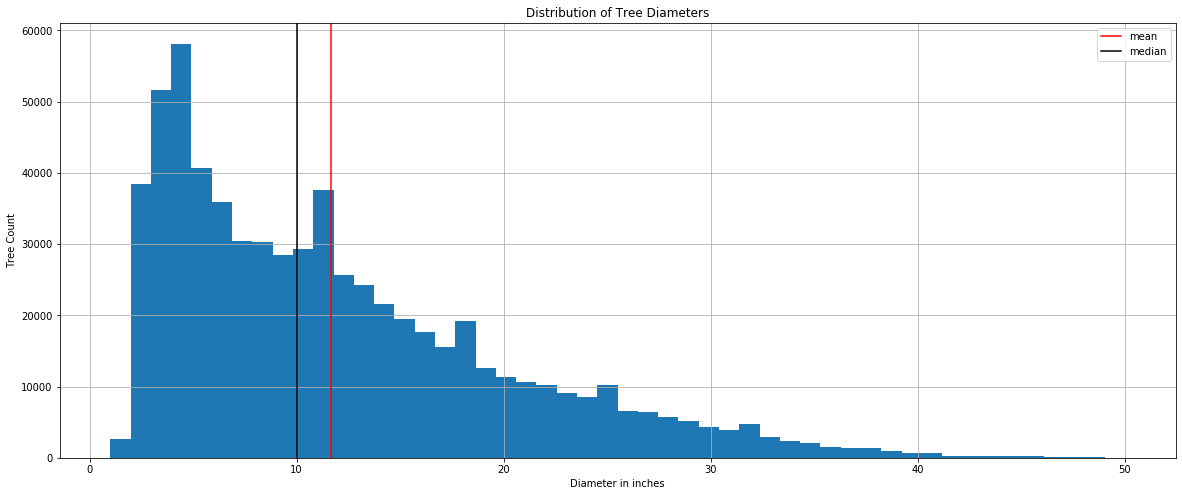

In [60]:
plt.figure(figsize=(20, 8))
tree.tree_dbh.hist(bins=50)
plt.xlabel('Diameter in inches')
plt.ylabel('Tree Count')
plt.title('Distribution of Tree Diameters')
plt.axvline(np.mean(tree.tree_dbh), color='r', label='mean')
plt.axvline(np.median(tree.tree_dbh), color='k', label='median')
plt.legend()
plt.show()

In [61]:
# printing the mean and median

print('Mean Value: ', np.mean(tree.tree_dbh))
print('Median Value: ', np.median(tree.tree_dbh))

Mean Value:  11.674665213687677
Median Value:  10.0


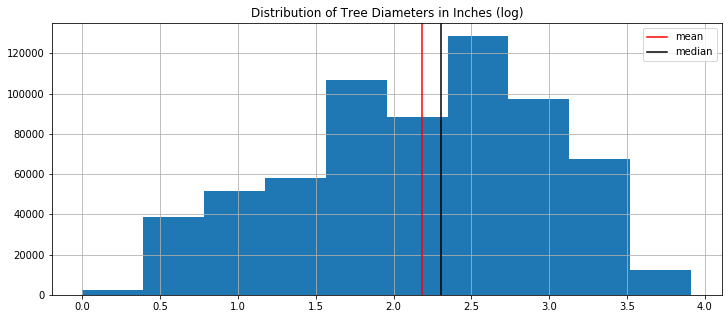

In [62]:
# take the log of tree_dbh

dbh_log = np.log(tree.tree_dbh)

plt.figure(figsize=(12, 5))
dbh_log.hist()
plt.title('Distribution of Tree Diameters in Inches (log)')
plt.axvline(np.mean(dbh_log), color='r', label='mean')
plt.axvline(np.median(dbh_log), color='k', label='median')
plt.legend()
plt.show() # the distribution appears closer to normal after taking the log

Taking the log of the diameters, the distribution is slightly skewed to the left but is closer to a normal distribution than previously.

Since we want to locate the true mean, we will calculate the 95% confidence interval.

In [63]:
# isolate diameters

diam = tree.tree_dbh

# 95% confidence interval, z score = 1.96

margin = (1.96 * np.std(diam)) / np.sqrt(len(diam))

lower = np.mean(diam) - margin
upper = np.mean(diam) + margin

print('Mean Value: ', np.mean(diam))
print('Lower Interval: ', lower)
print('Upper Interval: ', upper)

Mean Value:  11.674665213687677
Lower Interval:  11.65435006469371
Upper Interval:  11.694980362681642


In [64]:
np.percentile(diam, [2.5, 97.5]) # 95% of values are between 2 and 32

array([ 2., 32.])

In [65]:
# look into the correlation, tree diameters can explain the health of a tree

In [66]:
## Null Hypothesis: There is no correlation between the diameter of a tree and its health. (Is not an indicator)
## Alternate: The tree's diameter is an indicator of its health.

## Is this by chance or does diameter have an influence on health?

## Analyzing Problems Distribution

In [67]:
tree.num_problems.value_counts()

0    425892
1    162408
2     47714
3     12700
4      2520
5       248
6        49
7         2
9         1
8         1
Name: num_problems, dtype: int64

## Encoding Categorical Data

### root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

We'll start by looking at the root, trunk, and branch columns. Since each of these columns contain simple Yes or No options, we create a new column with labels indicating **0 for No and 1 for Yes**.

In [68]:
# transform and map root_stone

rs_le = LabelEncoder()
rs_labels = rs_le.fit_transform(tree.root_stone)
tree['root_stone_labels'] = rs_labels

In [69]:
# function to transform and map remaining columns

cols_transform = ['root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

for x in cols_transform:
    tree[x + '_labels'] = LabelEncoder().fit_transform(tree[x])

In [70]:
# display columns with labels

## remove original columns, keep the _labels

tree[['root_stone', 'root_stone_labels', 'root_grate', 'root_grate_labels', 'root_other', 'root_other_labels', 'trunk_wire', 'trunk_wire_labels', 'trnk_light', 'trnk_light_labels', 'trnk_other', 'trnk_other_labels', 'brch_light', 'brch_light_labels', 'brch_shoe', 'brch_shoe_labels', 'brch_other', 'brch_other_labels']].head()

,root_stone,root_stone_labels,root_grate,root_grate_labels,root_other,root_other_labels,trunk_wire,trunk_wire_labels,trnk_light,trnk_light_labels,trnk_other,trnk_other_labels,brch_light,brch_light_labels,brch_shoe,brch_shoe_labels,brch_other,brch_other_labels
0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
1,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
2,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
3,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
4,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0


In [71]:
# overall view

tree.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,...,num_problems,root_stone_labels,root_grate_labels,root_other_labels,trunk_wire_labels,trnk_light_labels,trnk_other_labels,brch_light_labels,brch_shoe_labels,brch_other_labels
0,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
1,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0
2,3,OnCurb,Good,honeylocust,1or2,None,Damage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
3,10,OnCurb,Good,honeylocust,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0
4,21,OnCurb,Good,American linden,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0


Next, we use the label encoder for the other columns.

### Curb Location (curb_loc), Stewards, Guards, Sidewalk, and Borough

In [72]:
## use the same encoder for all categorical variables

We assign a numerical value for each categorical answer and display the mapping.

In [73]:
cols_encode = ['curb_loc', 'steward', 'guards', 'sidewalk', 'borough', 'health']

# for x in cols_encode:
#     tree[x + '_labels'] = LabelEncoder().fit_transform(tree[x])

cat_mapping = []

for x in cols_encode:
    lencode = LabelEncoder()
    tree[x + '_labels'] = lencode.fit_transform(tree[x])
    mapped = {index: label for index, label in enumerate(lencode.classes_)}
    cat_mapping.extend(('Column Name: ' + x, mapped)) # added 'Column Name' for reference purposess

In [74]:
display(cat_mapping)

## these variables are nominal, but should they still be assigned to a certain number? Could some be ordinal?
## Ex. for health, should poor be assigned 0 instead of 2?

## borough variables are not in any order, they do not have different weights based on which borough they are in
## consider rearranging depending on which borough has the most trees?

['Column Name: curb_loc',
 {0: 'OffsetFromCurb', 1: 'OnCurb'},
 'Column Name: steward',
 {0: '1or2', 1: '3or4', 2: '4orMore', 3: 'None'},
 'Column Name: guards',
 {0: 'Harmful', 1: 'Helpful', 2: 'None', 3: 'Unsure'},
 'Column Name: sidewalk',
 {0: 'Damage', 1: 'NoDamage'},
 'Column Name: borough',
 {0: 'Bronx', 1: 'Brooklyn', 2: 'Manhattan', 3: 'Queens', 4: 'Staten Island'},
 'Column Name: health',
 {0: 'Fair', 1: 'Good', 2: 'Poor'}]

In [75]:
tree.curb_loc.value_counts()

OnCurb            625736
OffsetFromCurb     25799
Name: curb_loc, dtype: int64

In [76]:
# display part of the result

tree[['health', 'health_labels', 'curb_loc', 'curb_loc_labels', 'steward', 'steward_labels', 'guards', 'guards_labels', 'sidewalk', 'sidewalk_labels', 'borough', 'borough_labels']].head()

,health,health_labels,curb_loc,curb_loc_labels,steward,steward_labels,guards,guards_labels,sidewalk,sidewalk_labels,borough,borough_labels
0,Fair,0,OnCurb,1,None,3,None,2,NoDamage,1,Queens,3
1,Fair,0,OnCurb,1,None,3,None,2,Damage,0,Queens,3
2,Good,1,OnCurb,1,1or2,0,None,2,Damage,0,Brooklyn,1
3,Good,1,OnCurb,1,None,3,None,2,Damage,0,Brooklyn,1
4,Good,1,OnCurb,1,None,3,None,2,Damage,0,Brooklyn,1


### Tree Types (spc_common)

There are 132 unique kinds of trees. The number of trees vastly outnumber the answer types for the other columns so we are choosing not to use spc_common as a factor for our model.

In [77]:
print('Number of unique trees: ', len(tree.spc_common.unique()))

Number of unique trees:  132


## Combining the Columns

In [80]:
# reorganize the dataset so that label columns are next to their original columns

tree_labeled = pd.concat([tree[['health',
                               'health_labels',
                               'num_problems',
                               'tree_dbh', 
                               'curb_loc', 
                               'curb_loc_labels', 
                               'steward', 
                               'steward_labels', 
                               'guards', 
                               'guards_labels', 
                               'sidewalk', 
                               'sidewalk_labels', 
                               'borough', 
                               'borough_labels',
                               'root_stone', 
                               'root_stone_labels', 
                               'root_grate', 
                               'root_grate_labels',
                               'root_other', 
                               'root_other_labels', 
                               'trunk_wire', 
                               'trunk_wire_labels', 
                               'trnk_light', 
                               'trnk_light_labels', 
                               'trnk_other', 
                               'trnk_other_labels', 
                               'brch_light', 
                               'brch_light_labels', 
                               'brch_shoe', 
                               'brch_shoe_labels', 
                               'brch_other', 
                               'brch_other_labels', 
                              ]]], axis=1)

tree_labeled.head(10)

,health,health_labels,num_problems,tree_dbh,curb_loc,curb_loc_labels,steward,steward_labels,guards,guards_labels,...,trnk_light,trnk_light_labels,trnk_other,trnk_other_labels,brch_light,brch_light_labels,brch_shoe,brch_shoe_labels,brch_other,brch_other_labels
0,Fair,0,0,3,OnCurb,1,None,3,None,2,...,No,0,No,0,No,0,No,0,No,0
1,Fair,0,1,21,OnCurb,1,None,3,None,2,...,No,0,No,0,No,0,No,0,No,0
2,Good,1,0,3,OnCurb,1,1or2,0,None,2,...,No,0,No,0,No,0,No,0,No,0
3,Good,1,1,10,OnCurb,1,None,3,None,2,...,No,0,No,0,No,0,No,0,No,0
4,Good,1,1,21,OnCurb,1,None,3,None,2,...,No,0,No,0,No,0,No,0,No,0
5,Good,1,0,11,OnCurb,1,1or2,0,Helpful,1,...,No,0,No,0,No,0,No,0,No,0
6,Good,1,0,11,OnCurb,1,1or2,0,Helpful,1,...,No,0,No,0,No,0,No,0,No,0
7,Good,1,1,9,OnCurb,1,None,3,None,2,...,No,0,No,0,No,0,No,0,No,0
8,Good,1,0,6,OnCurb,1,None,3,None,2,...,No,0,No,0,No,0,No,0,No,0
9,Fair,0,0,21,OffsetFromCurb,0,None,3,None,2,...,No,0,No,0,No,0,No,0,No,0


In [81]:
print('The dataset has {} rows and {} columns.'.format(tree_labeled.shape[0], tree_labeled.shape[1]))

The dataset has 651535 rows and 32 columns.
